# Material Balances XII

This lecture considers how to arrange sequences of reactors in series. We will apply Levenspiel Plots for this analysis as they are very useful for building insights about how to properly ***sequence*** reactors, even if we may not use them to actually ***size*** the reactors. They are an outstanding tool for developing an understanding of how reactor size will scale with rate of reaction!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import quad, solve_ivp
from scipy.interpolate import interp1d
from math import ceil, floor

## Flow Reactors in Series

For this analysis, we will continue to consider the same irreversible reaction involving two components that we did in [Notebook 25](https://jqbond.github.io/CEN587/Notebooks/587-N25.html). The main thing we will change today is that instead of considering a single CSTR or a single PFR, we will consider series of flow reactors. These series of reactors could be multiple PFRs, multiple CSTRs, or a mix of the two in various orders and configurations. 

$$A \longrightarrow B$$

Just like we did in [Notebook 25](https://jqbond.github.io/CEN587/Notebooks/587-N25.html) we will state explicity at the outset that all examples in this notebook will use the assumptions that all parameters $(k, \ C_{Af}, \ F_{Af}, \ Q)$ have a numerical value of 1 and that the units of the rate constant are going to vary with reaction order so that they always produce an intensive reaction rate that has units of moles per liter per time, and that anytime we use material balance to calculate reactor volume, that volume will always be in liters. We will also assume that density, temperature, pressure, volumetric flowrates, etc. are all going to be constant at all positions throughout any series of reactors that we propose. Finally, all flow reactors considered here will operate at steady state. The assumption of constant density at steady state allows us to make the following simplification, which makes solutions a bit neater:

$$C_A = C_{A,f} \, (1 - X_A)$$

We will now consider carrying out a reaction in a set of flow reactors in sequence instead of in a single flow reactor:

```{figure} ../images/ReactorsInSeries1.svg
---
scale: 20%
name: ReactorsInSeries1
---
Flow Reactors in Series
```

Consider that there are no splitters, mixers, or separations in this PFD. We can therefore express the molar flowrate of species A at any point in this sequence, $F_{Ai}$ in terms of the feed molar flowrate to the *process*, $F_{A0}$ and the overall conversion achieved at a particular point in the sequence $X_{Ai}$.  In other words:

\begin{align*}
    F_{A0} &= F_{A0} \, (1 - X_{A0}) = F_{A0}  - F_{A0}X_{A0}\\
    F_{A1} &= F_{A0} \, (1 - X_{A1}) = F_{A0}  - F_{A0}X_{A1}\\
    F_{A2} &= F_{A0} \, (1 - X_{A2}) = F_{A0}  - F_{A0}X_{A2}\\
    F_{A3} &= F_{A0} \, (1 - X_{A3}) = F_{A0}  - F_{A0}X_{A3}\\
    F_{A4} &= F_{A0} \, (1 - X_{A4}) = F_{A0}  - F_{A0}X_{A4}\\
\end{align*}

Let's recall our generic balance on a single CSTR solved for Volume:

$$V_\textrm{CSTR} = \frac{F_{A,f}X_A}{r \, (X_A)}$$

And the same for a generic balance on a single PFR solved for Volume:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A,f} \, dX_A}{r \, (X_A)}$$

Looking at these balance equations, we remind ourselves that the size of the reactor scales directly with the quantity of species converted in that reactor. The more stuff that we convert in the reactor, the larger it needs to be. Let's generalize the concept of the "quantity of stuff that gets converted in the reactor." For example, you could look at Reactor 1 and say that the quantity of $A$ consumed in **Reactor 1** is given by $F_{A0} - F_{A1}$. We can express this quantity in terms of conversions at point 0 ($X_{A0}$, inlet to **Reactor 1**) and point 1 ($X_{A1}$, exit of **Reactor 1**) using the results above:

$$F_{A0} - F_{A1} = [F_{A0}  - F_{A0}X_{A0}] - [F_{A0}  - F_{A0}X_{A1}]$$

We can simplify this significantly:

$$F_{A0} - F_{A1} = F_{A0} \, (X_{A1} - X_{A0})$$

Similarly, if we wanted to express the quantity of $A$ converted across **Reactor 2** in terms of the process feed, $F_{A0}$, and fractional conversions into and out of **Reactor 2**, we would write:

$$F_{A1} - F_{A2} = [F_{A0}  - F_{A0}X_{A1}] - [F_{A0}  - F_{A0}X_{A2}]$$

Which simplifies to:

$$F_{A1} - F_{A2} = F_{A0} \, (X_{A2} - X_{A1})$$

We can see a pattern emerging -- for the "nth" flow reactor in a series, we can quantify the amount of reactant converted in that reactor as:

$$F_{A_{(n-1)}} - F_{A_n} = F_{A0} \, \left(X_{A_n} - X_{A_{(n-1)}}\right)$$

### Consider the $n^{th}$ reactor

Now, let's think conceputally about that $n^{th}$ reactor in the sequence (see figure below). We want to imagine that this reactor is either a PFR or a CSTR. Once we do that, we can write a balance for that $n^{th}$ reactor.

```{figure} ../images/ReactorsInSeriesn.svg
---
scale: 20%
name: ReactorsInSeriesn
---
Flow Reactors in Series
```

#### What if the $n^{th}$ reactor is a CSTR...

If we assume that the $n^{th}$ reactor is a CSTR, then we can write the following balance on **Reactor n**

$$0 = F_{A_{(n-1)}} - F_{A_n} + R_{A_n}V_{\textrm{CSTR}_n}$$

We can solve this equation symbolically for the volume of the $n^{th}$ reactor:

$$V_{\textrm{CSTR}_n} = \frac{F_{A_{(n-1)}} - F_{A_n}}{-R_{A_n}}$$

We also know that, for this $A \longrightarrow B$ reaction, $R_{A_n} = -r_n$, i.e., it is the negative rate of reaction in the reactor n. We make this substitution to find:

$$V_{\textrm{CSTR}_n} = \frac{F_{A_{(n-1)}} - F_{A_n}}{r_n}$$

It is critically important to understand that the rate of reaction in a CSTR (**Reactor n**) is determined by the concentration of species ***inside of Reactor n***. We should take a moment to convince ourselves that, because this is a CSTR, ***the concentrations of species inside of Reactor n*** are exactly equal to ***the concentrations of species in the exit stream from the Reactor n***.  We can replace the difference in molar flowrates in the numerator with the fractional conversion expression from above to get:

$$V_{\textrm{CSTR}_n} = \frac{F_{A0}}{r_n} \, \left(X_{A_n} - X_{A_{(n-1)}}\right)$$

In order to actually solve this, we have to specify a rate law. We will again use generic power law kinetics and say that:

$$r = k{C_A}^\alpha$$

With that, we can write a generic function to solve for the volume of the $n^{th}$ reactor, which is a CSTR in this example. To use the function below, we need to do is pass a specific  reaction order $\alpha$, a specific value of fractional conversion of A in the influent to **Reactor n**, $X_{A_{(n-1)}}$, and the fractional conversion of A in the effluent of **Reactor n**, $X_{A_n}$.

In [21]:
def VCSTR(XAin, XAout, α):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    CA  = CAf*(1 - XAout)
    r   = k*CA**α
    V   = FAf*(XAout - XAin)/r
    return V

##### Sizing a single CSTR...

Now that we have this, we'll use it to calculate the CSTR volume required to take the system from 0% to 90% conversion across a single reactor in the case of first order kinetics; we find that it is 9.0L as we did in [Notebook 25](https://jqbond.github.io/CEN587/Notebooks/587-N25.html).

In [23]:
α_test = 1
XA0 = 0.0
XA1 = 0.9

VC  = VCSTR(XA0, XA1, α_test)
print(f'For α = {α_test:3.1f}: \n XA = {XA1:4.2f} at VCSTR = {VC:3.2f}L')

For α = 1.0: 
 XA = 0.90 at VCSTR = 9.00L


##### What if we instead use 2 CSTRs in series?

Now let's do something different.  Let's set up two CSTRs in series and have them achieve 90% conversion together. Specifically, we will design them such that the fractional conversion of species $A$ is 90% at the exit of the 2nd reactor. For simplicity, we will design it so that the first CSTR achieves 45% conversion (it takes the system from 0% conversion to 45% conversion), and the second CSTR will achieve the remainder (it takes the system from 45% conversion to 90% conversion).

We should be able to apply the function above twice.  In the first case, it will take the following arguments, which will return the volume of the 1st CSTR in liters:

`V1 = VCSTR(0.00, 0.45, 1)`

The result of the above is $V1 = 0.82 \mathrm{L}$. In the second case, it will take the following arguments, which will return the volume of the 2nd CSTR in liters:

`V2 = VCSTR(0.45, 0.90, 1)`

The result of this function evaluation is $V2 = 4.50 \mathrm{L}$

In [24]:
α_test = 1
XA0 = 0.0
XA1 = 0.45
XA2 = 0.90

VC1 = VCSTR(XA0, XA1, α_test)
VC2 = VCSTR(XA1, XA2, α_test)
VCT = VC1 + VC2
print(f'Achieving 90% conversion in a single CSTR requires V = {VC:3.2f}L \n')
print(f'Going from 0% to 45% conversion requires  V1 = {VC1:3.2f}L')
print(f'Going from 45% to 90% conversion requires V2 = {VC2:3.2f}L')
print(f'If we use two CSTRs to get to 90%, the total volume is V = {VCT:3.2f}L')

Achieving 90% conversion in a single CSTR requires V = 9.00L 

Going from 0% to 45% conversion requires  V1 = 0.82L
Going from 45% to 90% conversion requires V2 = 4.50L
If we use two CSTRs to get to 90%, the total volume is V = 5.32L


That's interesting!  The first CSTR requires 0.82L of volume to go to 45% conversion, and the second CSTR requires 4.50L to go from 45% to 90% conversion.  If we add those together, that's 5.32L of total CSTR volume if we divide the system into 2 CSTRs, each accomplishing half of the required conversion.  In contrast, if we try to do this in a single CSTR, it costs us 9.0L of reactor volume. Why is that so?  It has to do with the fact that CSTRs are assumed to be perfectly mixed, and they operate entirely at the exit conversion. If we try to achive 90% conversion in a single reactor, that entire reactor operates at 90% conversion and the concentration of $A$ inside of that reactor is 10% of its feed value. This is a relatively low concentration of $A$, and, for a positive order, this causes the rate of reaction to be relatively low throughout that reactor. For this reason, it requires a relatively large volume of 9.0L.

In contrast, if we divide this into two reactors, the first one operates at 45% conversion, so the concentration of species $A$ in that reactor is $0.55C_{Af}$, which is relatively high.  Because we are currently considering a positive order reaction, this means the rate in that first reactor is realtively high compared to the example of a single CSTR operating at 90% conversion ($0.1C_{Af}$). So the first CSTR in a sequence converts 45% of the feed at a relatively high reaction rate; hence it requires a relatively small volume of 0.82L.

The second reactor is operating at 90% conversion ($0.1C_{Af}$), which means it will have a relatively low reaction rate in this case of first order kinetics; however, because we have divided this process into two reactors, the second reactor only has to convert 45% of the feed. This means that the quantity of "stuff" converted inside of Reactor 2 is relatively small. This helps to mitigate the impact of operating the reactor at a low rate of reaction, and we have a smaller second reactor than the 9.0L we'd need to convert 90% of the feed in a single CSTR. 

Adding them together, we find that we only need 5.30L of reactor volume if we split the process this way. The difference between a single CSTR and two CSTRs in series is illustrated very clearly on on a Levenspiel Plot:

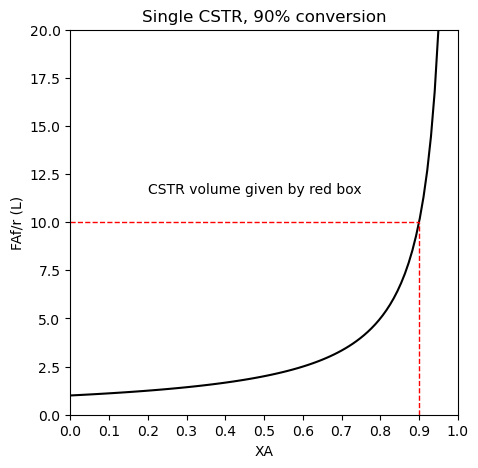

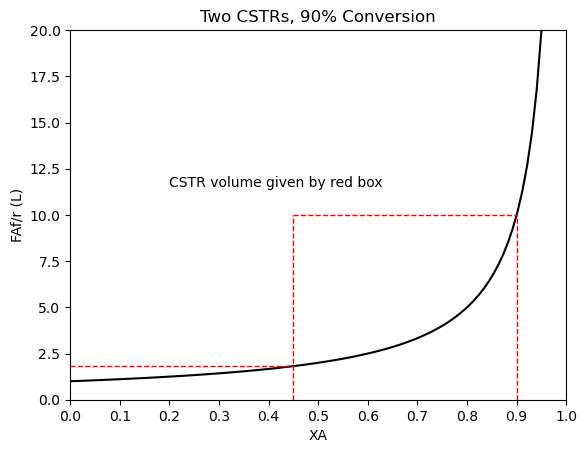

In [29]:
def LEV(XA, α):
    k   = 1 #units to vary with reaction order so that r = mol/L/min
    CAf = 1 #mol/L
    FAf = 1 #mol/min
    CA  = CAf*(1 - XA)
    r   = k*CA**α
    return FAf/r

order = 1
XAset = np.linspace(0, 0.95, 100)
plt.figure(1, figsize = (5, 5))
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.vlines(0.9, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0.0, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red box', (0.2, 11.5))
plt.title('Single CSTR, 90% conversion')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0,20)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.vlines(0.9, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0.45, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(0.45, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.45, order), 0, 0.45, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red box', (0.2, 11.5))
plt.title('Two CSTRs, 90% Conversion')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0,20)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

#### What if the $n^{th}$ reactor is a PFR...

Now let's consider the case where **Reactor n** is a PFR. Generally, if we write a balance on species $A$ in a PFR, express molar flowrates as functions of fractional conversion, and solve for reactor volume, we get the following expression:

$$V_\textrm{PFR} = \int_0^{X_A}\frac{F_{A0} \, dX_A}{r \, (X_A)}$$

This balance is a differential equation. We must integrate to account for continuous variation in reaction rate as a function of fractional conversion. Because of this, we don't need to modify it very much to consider the volume **Reactor n**.  We just need to write this differential equation so that it accounts for the incremental changes in fractional conversion (and therefore reaction rate) that occur between the inlet of **Reactor** n and the exit of **Reactor n**. We accomplish this by adjusting the limits of integration so that they correspond to the inlet of the reactor (lower limit of integration) and the exit of the reactor (upper limit of integration). For example, in [Notebook 25](https://jqbond.github.io/CEN587/Notebooks/587-N25.html), we calculated the volume of a single PFR. We did so by integrating from a lower limit of $X_{A0} = 0$ at the inlet of this single reactor to an upper limit of $X_{A1}$ at the exit of the first reactor (whatever conversion we're trying to achieve in that reactor). If we want to think about the $n^{th}$ PFR in a series, we would just account for this by generalizing the limits of integration to $X_{A_{n-1}}$ (lower limit) and $X_{A_n}$ (upper limit).

$$V_{\textrm{PFR}_n} = \int_{X_{A_{(n-1)}}}^{X_{A_n}} \frac{F_{A0} \, dX_A}{r \, (X_A)}$$

Once we have a rate law, we can solve the above express (1) analytically, (2) with an ODE solver, or, in this case of a definite integral, (3) using gaussian quadrature. Let's use that the last option here since it is easy for us to generalize to any reaction order in power law kinetics:

$$r = k{C_A}^\alpha$$

In [30]:
def VPFR(XAin, XAout, α):
    FAf = 1 #mol/min
    Qf  = 1 #mol/min
    CAf = 1 #mol/L
    k   = 1 #1/min
    CA  = lambda X: CAf*(1 - X)
    r   = lambda X: k*CA(X)**α
    intfun   = lambda X: FAf/r(X)
    vol, err = quad(intfun, XAin, XAout)
    return vol

##### Sizing a single PFR...

Now that this is done, we'll calculate the PFR volume required to take the system from 0% conversion to 90% conversion in a single reactor. As in [Notebook 25](https://jqbond.github.io/CEN587/Notebooks/587-N25.html), we find that this will require a 2.3L PFR.

In [31]:
α_test
XA0 = 0.0
XA1 = 0.9

VP  = VPFR(XA0, XA1, 1)
print(f'For α = {α_test:3.1f}: \n XA = {XA1:4.2f} at VPFR = {VP:3.2f}L')

For α = 1.0: 
 XA = 0.90 at VPFR = 2.30L


##### What if we instead use 2 CSTRs in series?

We will handle this by evaluating two definite integrals corresponding to the first and second PFR. For comparison with the CSTRs-in-series result, we will design the first PFR so that it accomplishes 45% conversion, and we will design the second PFR so that it accomplishes the balance and brings the system from 45% conversion of $A$ to 90% conversion of $A$. We do this by evaluating the `VPFR` function twice with different arguments:

For the first PFR, we calculate:

`VP1 = VPFR(0.00, 0.45, 1)`

We find that it requires a volume of 0.6L to achieve 45% conversion.  For the second PFR, we calculate:

`VP2 = VPFR(0.45, 0.90, 1)`

We find that the second PFR requires a volume of 1.7L. If we add those together, we get that the total PFR volume requires is 2.30L. This is identical to the PFR volume required to go from 0% conversion to 90% conversion in a single reactor. 

In [32]:
α_test = 1
XA0 = 0.0
XA1 = 0.45
XA2 = 0.90

VP1 = VPFR(XA0, XA1, α_test)
VP2 = VPFR(XA1, XA2, α_test)
VPT = VP1 + VP2
print(f'Achieving 90% conversion in a single PFR requires V = {VP:3.2f}L \n')
print(f'Going from 0% to 45% conversion requires  V1 = {VP1:3.2f}L')
print(f'Going from 45% to 90% conversion requires V2 = {VP2:3.2f}L')
print(f'If we use two PFRs to get to 90%, the total volume is V = {VPT:3.2f}L')

Achieving 90% conversion in a single PFR requires V = 2.30L 

Going from 0% to 45% conversion requires  V1 = 0.60L
Going from 45% to 90% conversion requires V2 = 1.70L
If we use two PFRs to get to 90%, the total volume is V = 2.30L


Huh.  We see that each reactor is smaller, but that makes sense because they are accomplishing less conversion compared to the single, 2.30L reactor that is achieving 90% conversion in one shot.  But if we add them up, we get an identical result to what we got for a single PFR.  Again, the reason for this is evident if you look at a Levenspiel plot:

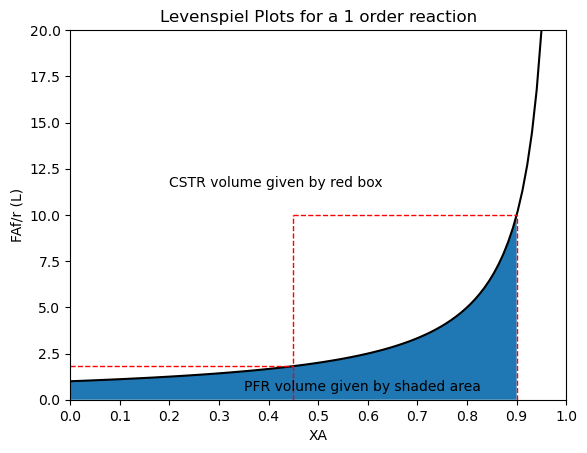

In [33]:
order = 1
XAset = np.linspace(0, 0.95, 100)
XAPFR = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAPFR, LEV(XAPFR, order))
plt.vlines(0.9, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.9, order), 0.45, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(0.45, 0, 10, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEV(0.45, order), 0, 0.45, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.annotate('CSTR volume given by red box', (0.2, 11.5))
plt.annotate('PFR volume given by shaded area', (0.35, 0.5))
plt.title(f'Levenspiel Plots for a {order} order reaction')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Since PFRs take the system from inlet conditions to exit conditions in a series of differential steps, the volume of the PFR is given by the area under the Levenspiel curve, and there is absolutely no difference if we use a single PFR or if we divide the system into two PFRs. If you further consider dividing the system into 3, 4, 5, or ∞ PFRs, you'll always find that the total volume required is the same as that for a single PFR. 

##### What if we used a lot of reactors in series?

The code cell below is generalized so that you can compare the total PFR and CSTR volumes required to achieve any desired conversion for any desired reaction order. First, let's consider the case of increasing the number of reactors in a series for first order kinetics. As we do so, we will will notice a few things:

1. The total PFR volume will never change.
2. The total CSTR volume decreases as the number of CSTRs increases.
3. As $n \rightarrow \infty$, we find that for total reactor volumes, $V_{\mathrm{CSTR}} \rightarrow V_{\mathrm{PFR}}$

```{note}
If one applies the simplifying assumptions of this analysis (isothermal, isobaric, constant density, etc.), these results about reactor sequencying are always true for positive order kinetics!

The convergence between (total) CSTR volume and PFR volume makes sense when you think about the model that we used to develop the PFR material balance. Essentially, we apply the assumption that a PFR is comprised of an infinite number of axial cross sections, each of which has uniform temperature, pressure, and composition (just like a CSTR!). It makes sense, then, that when we divide a system into an infinite series of CSTRs that the total volume therein will approach that of a single PFR.
```

The total PFR volume required is  V = 2.30L
The total CSTR volume required is V = 5.32L


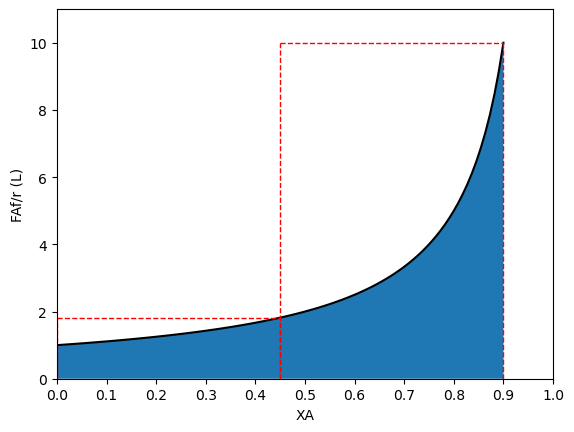

In [42]:
order = 1
XAset = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAPFR, LEV(XAPFR, order))

XAMAX = max(XAset)
NREAC = 2
XAVAL = np.linspace(0, XAMAX, NREAC+1)
VCSET = np.zeros(len(XAVAL))
VPSET = np.zeros(len(XAVAL))
for i in range(0, len(XAVAL)-1):
    plt.vlines(XAVAL[i], 0, LEV(XAVAL[i+1], order), linestyle = 'dashed', color = 'red', linewidth = 1)
    plt.vlines(XAVAL[i+1], 0, LEV(XAVAL[i+1], order), linestyle = 'dashed', color = 'red', linewidth = 1)
    plt.hlines(LEV(XAVAL[i+1], order), XAVAL[i], XAVAL[i+1], linestyle = 'dashed', color = 'red', linewidth = 1)
    VCSET[i] = VCSTR(XAVAL[i], XAVAL[i+1], order)
    VPSET[i] = VPFR(XAVAL[i], XAVAL[i+1], order)

print(f'The total PFR volume required is  V = {sum(VPSET):3.2f}L') 
print(f'The total CSTR volume required is V = {sum(VCSET):3.2f}L')

plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

##### What if we have zero order kinetics?

We'll repeat the above experiment of increasing the number of reactors for zero order kinetics.

1. The total PFR volume will never change.
2. The total CSTR volume will never change.
3. For total reactor volumes, $V_{\mathrm{CSTR}} = V_{\mathrm{PFR}}$

```{note}
This makes sense -- we see differences in PFR and CSTR sizes when the spatially averaged rate of reaction inside of each reactor is different. For zero order kinetics (in an isothermal system), reaction rates are not affected by changes in concentration, so we get identical reaction rates in a PFR and a CSTR. As a consequence, the two reactors will be exactly the same size, and dividing a process into a series of reactors has no effect on total volume.
```

The total PFR volume required is  V = 0.90L
The total CSTR volume required is V = 0.90L


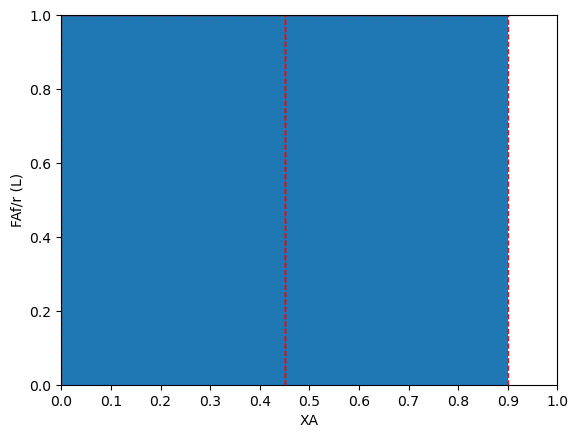

In [44]:
order = 0
XAset = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAPFR, LEV(XAPFR, order))

XAMAX = max(XAset)
NREAC = 2
XAVAL = np.linspace(0, XAMAX, NREAC+1)
VCSET = np.zeros(len(XAVAL))
VPSET = np.zeros(len(XAVAL))
for i in range(0, len(XAVAL)-1):
    plt.vlines(XAVAL[i], 0, LEV(XAVAL[i+1], order), linestyle = 'dashed', color = 'red', linewidth = 1)
    plt.vlines(XAVAL[i+1], 0, LEV(XAVAL[i+1], order), linestyle = 'dashed', color = 'red', linewidth = 1)
    plt.hlines(LEV(XAVAL[i+1], order), XAVAL[i], XAVAL[i+1], linestyle = 'dashed', color = 'red', linewidth = 1)
    VCSET[i] = VCSTR(XAVAL[i], XAVAL[i+1], order)
    VPSET[i] = VPFR(XAVAL[i], XAVAL[i+1], order)

print(f'The total PFR volume required is  V = {sum(VPSET):3.2f}L') 
print(f'The total CSTR volume required is V = {sum(VCSET):3.2f}L')

plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

##### What if we have negative order kinetics?

We'll repeat the above experiment of increasing the number of reactors for negative order kinetics (e.g., -1, -2, -3/2, etc.).

1. The total PFR volume will never change.
2. The total CSTR volume will increase as we increase the number of reactors.
3. For total reactor volumes, $V_{\mathrm{CSTR}} = V_{\mathrm{PFR}}$

```{note}
With negative order kinetics, we find that rates of reaction increase as concentrations decrease. For this reason, it is advantageous to run reactors at low (rather than high) feed concentrations. When we encounter situations like this -- where rates of reaction increase as conversion increases -- we will find that a single CSTR will give the smallest possible volume.
```

The total PFR volume required is  V = 0.50L
The total CSTR volume required is V = 0.45L


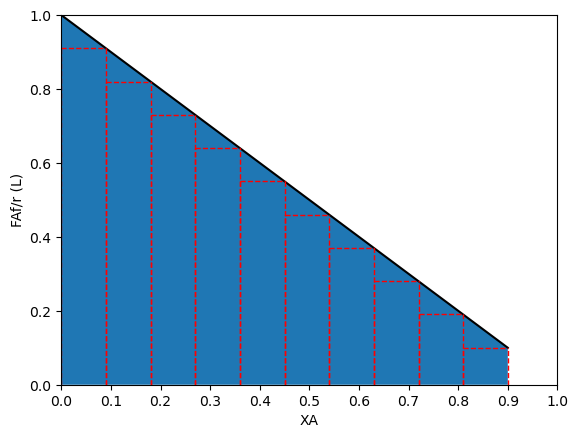

In [46]:
order = -1
XAset = np.linspace(0, 0.90, 100)
plt.plot(XAset, LEV(XAset, order), color = 'black')
plt.fill_between(XAPFR, LEV(XAPFR, order))

XAMAX = max(XAset)
NREAC = 10
XAVAL = np.linspace(0, XAMAX, NREAC+1)
VCSET = np.zeros(len(XAVAL))
VPSET = np.zeros(len(XAVAL))
for i in range(0, len(XAVAL)-1):
    plt.vlines(XAVAL[i], 0, LEV(XAVAL[i+1], order), linestyle = 'dashed', color = 'red', linewidth = 1)
    plt.vlines(XAVAL[i+1], 0, LEV(XAVAL[i+1], order), linestyle = 'dashed', color = 'red', linewidth = 1)
    plt.hlines(LEV(XAVAL[i+1], order), XAVAL[i], XAVAL[i+1], linestyle = 'dashed', color = 'red', linewidth = 1)
    VCSET[i] = VCSTR(XAVAL[i], XAVAL[i+1], order)
    VPSET[i] = VPFR(XAVAL[i], XAVAL[i+1], order)

print(f'The total PFR volume required is  V = {sum(VPSET):3.2f}L') 
print(f'The total CSTR volume required is V = {sum(VCSET):3.2f}L')

plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEV(XAset, order))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

### How do we leverage and extend these insights?

Now let's consider why these concepts might be useful. Below, we will create a Levenspiel plot based on an arbitrary rate law. In this case, it is a made up rate law that results in a reaction rate that is parabolic in fractional conversion and has a maximum rate at $X_A \approx 0.45$. Although the rate law is contrived, this example is not! This type of behavior is very common! Specifically, when we run exothermic reactions in adiabatic reactors, we will often observe that rate of reaction increases with fractional conversion (even though reactant concentration is decreasing). This behavior arises because, for an exothermic reaction in an adiabatic reactor, the reactor temperature will increase as a function of feed conversion. Rate constants have an exponential dependence on temperature $(k = A\exp\left(-E_A/RT\right))$, and this is more than enough to offset the decrease in concentration. As a result, we see that the rate of reaction increases despite a decrease in the concentration of species $A$. *Eventually*, the concentration of $A$ decreases to the point where it negates the effect of an increasing rate constant, and the reaction begins to slow down again (with increasing conversion).  The example below mimics this behavior.

In [47]:
def rmod(XA):
    k   = 1 #units to vary with reaction order so that r = mol/L/min
    CAf = 1 #mol/L
    FAf = 1 #mol/min
    r   = 1 - 3*(XA - 0.45)**2
    return r

def LEVmod(XA):
    k   = 1 #units to vary with reaction order so that r = mol/L/min
    CAf = 1 #mol/L
    FAf = 1 #mol/min
    r   = 1 - 3*(XA - 0.45)**2
    return FAf/r

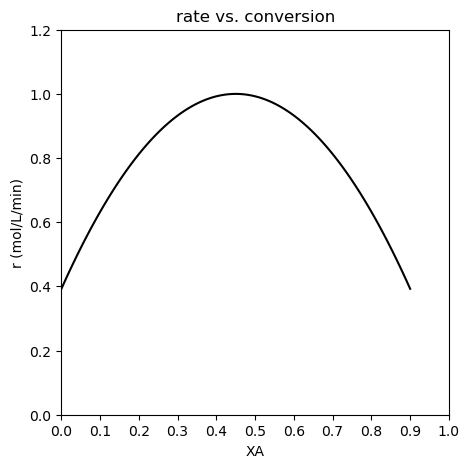

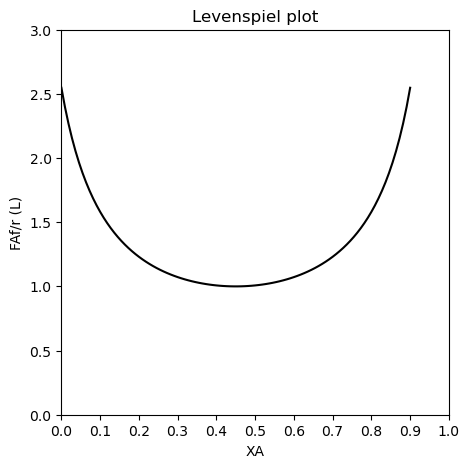

In [48]:
XAset  = np.linspace(0, 0.90, 100)
XAPFR1 = np.linspace(0.45, 0.9, 100)
XAPFR2 = np.linspace(0.0, 0.45, 100)

plt.figure(figsize = (5, 5))
plt.plot(XAset, rmod(XAset), color = 'black')
plt.title('rate vs. conversion')
plt.ylabel('r (mol/L/min)')
plt.xlabel('XA')
plt.xlim(0, 1)
plt.ylim(0, ceil(max(rmod(XAset)))*1.2)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

plt.figure(figsize = (5,5))
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.title('Levenspiel plot')
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

#### What is the optimal reactor sequence for achieving 90% conversion for these kinetics?

Now let's say we want to achieve 90% conversion of species A in this system. Below, we illustrate the case for carrying this out in a single PFR.

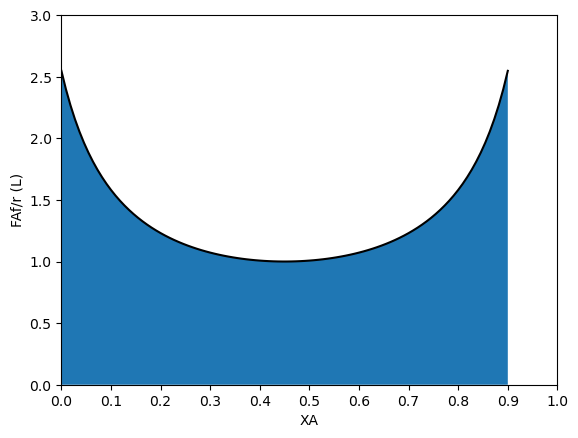

In [49]:
#Use for a single PFR
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.fill_between(XAset, LEVmod(XAset))
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Next, we consider the same transformation in a single CSTR

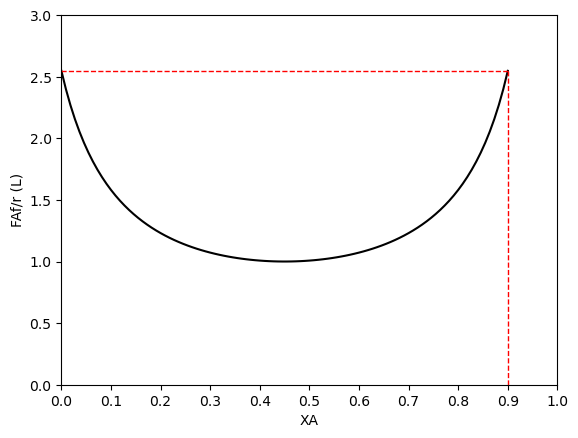

In [50]:
#Use for a single CSTR
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.vlines(0.9, 0, LEVmod(0.9), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEVmod(0.9), 0.00, 0.9, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

We can compare that to using 2 CSTRs in series; there is an important question of what the intermediate conversion out of the first reactor should be to minimize reactor volume. It is not obvious where that intermediate conversion should be; we would need to perform some type of optimization strategy to determine this. We will save that for a future lecture after we cover optimization methods.

The total CSTR volume required is V = 1.60L


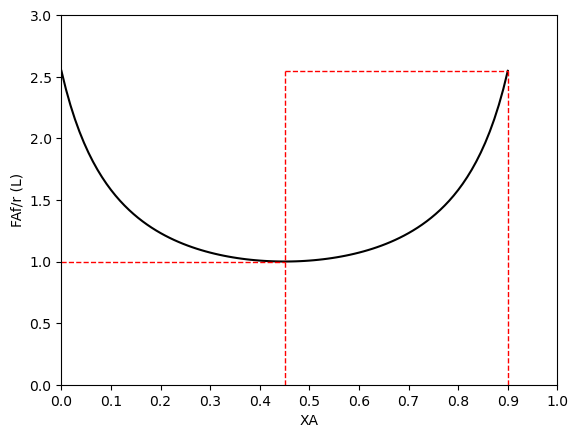

In [51]:
#Use for 2 CSTRs in series
XA0 = 0.0
XA1 = 0.45
XA2 = 0.90
VC1 = LEVmod(XA1)*(XA1 - XA0)
VC2 = LEVmod(XA2)*(XA2 - XA1)
VCT = VC1 + VC2
print(f'The total CSTR volume required is V = {VCT:3.2f}L')
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.vlines(XA2, XA0, LEVmod(XA2), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(XA1, XA0, LEVmod(XA2), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEVmod(XA2), XA1, XA2, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.hlines(LEVmod(XA1), XA0, XA1, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Now let's try mixing reactors; we'll put a CSTR in series downstream of a PFR and operate the PFR so that it achieves 45% conversion:

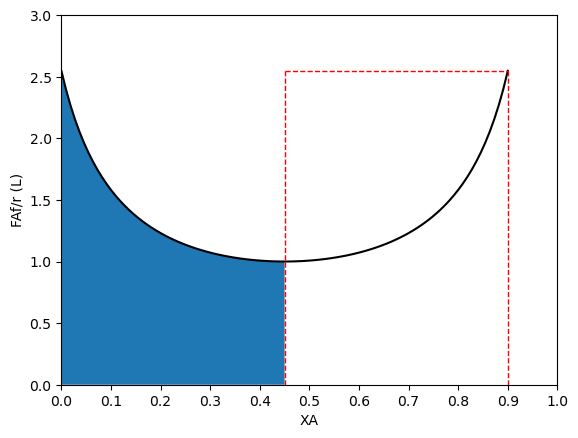

In [52]:
#Use for a PFR before a CSTR
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.vlines(0.9, 0, LEVmod(0.9), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.vlines(0.45, 0, LEVmod(0.9), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.fill_between(XAPFR2, LEVmod(XAPFR2))
plt.hlines(LEVmod(0.9), 0.45, 0.90, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

It is not intuitive at first, but if we switch the order and place the CSTR before the PFR, we get a much smaller total reactor volume:

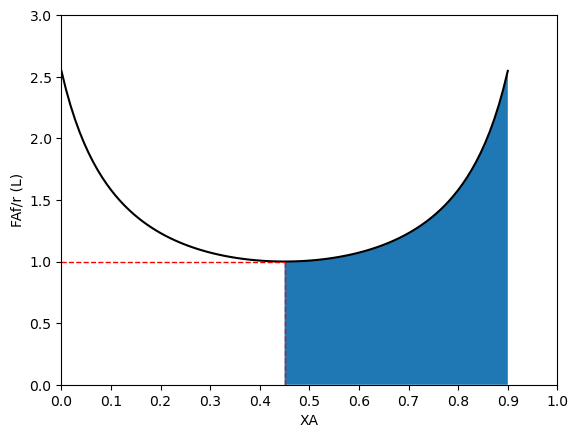

In [53]:
#Use for a CSTR before a PFR
plt.plot(XAset, LEVmod(XAset), color = 'black')
plt.vlines(0.45, 0, LEVmod(0.45), linestyle = 'dashed', color = 'red', linewidth = 1)
plt.fill_between(XAPFR1, LEVmod(XAPFR1))
plt.hlines(LEVmod(0.45), 0.00, 0.45, linestyle = 'dashed', color = 'red', linewidth = 1)
plt.ylabel('FAf/r (L)')
plt.xlabel('XA')
plt.xlim(0,1)
plt.ylim(0, ceil(max(LEVmod(XAset))))
plt.xticks(np.linspace(0, 1, 11))
plt.show()

These trends make sense when you consider (1) the impact of mixing, (2) the relationship of reactor size and reaction rate, and (3) the point of maximum reaction rate in this system. Essentially, you will be able to minimize reactor volume by ensuring that the system operates as close as possible to the maximum reaction rate for as long as possible.  The CSTR is perfectly mixed, so we can design it to operate at 45% conversion, i.e., the point of maximum reaction rate.  Thereafter, we'd like to gradually move from that point of maximum reaction rate (45% conversion) to the very low reaction rate we know we'll encounter at 90% conversion. A PFR is not mixed, and it will allow you to accomplish this gradual change in fractional conversion as a function of residence time (position in the reactor). 

```{tip}
In cases where reaction rates are not monotonic functions of fractional conversion, Levenspiel Plots are very useful for deciding on optimal reactor sequences.
```